In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision

In [0]:
%matplotlib inline

In [0]:
batch_size = 128
img_size = 32
channels = 3
nz = 100 #latent rep size

In [0]:
a=np.arange(10)
np.random.permutation(a)

array([4, 6, 3, 0, 7, 5, 2, 1, 8, 9])

Extracting ./data/cifar-10-python.tar.gz to ./data


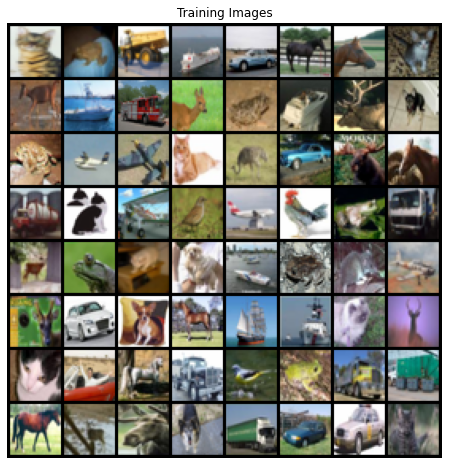

In [5]:
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform,)
a=np.arange(trainset.data.shape[0])
a=np.random.permutation(a)
b=45000

train_ds = Subset(trainset, a[:b])
val_ds = Subset(trainset, a[b:])
#trainset = torchvision.datasets.CIFAR10(root='./data', =True,
#                                        download=True)
batch_size2=2000
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the dataloader
dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

valloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size2,
                                         shuffle=True, num_workers=4)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

import torchvision.utils as vutils
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
#attention
from torch.nn import Parameter

class Self_Attn(nn.Module):
    def __init__(self,channels_in,channel_inter):
        super(Self_Attn,self).__init__()
        self.chanel_in = channels_in
        self.query_conv = nn.Conv2d(channels_in , channel_inter , kernel_size= 1)
        self.key_conv = nn.Conv2d(channels_in , channel_inter , kernel_size= 1)
        self.value_conv = nn.Conv2d(channels_in , channels_in , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1) #

    def forward(self,x):
        
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X N X C  N=W*H
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention



    
#spectral norm

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [0]:


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        layer=[]
        layer2=[]
        layer.append(SpectralNorm( nn.ConvTranspose2d( nz, img_size * 8, 4, 1, 0, bias=False) ))
        layer.append(nn.BatchNorm2d(img_size * 8))
        layer.append(nn.LeakyReLU(negative_slope=0.1, inplace=True))
        
        layer.append(SpectralNorm(nn.ConvTranspose2d(img_size * 8, img_size* 4, 4, 2, 1, bias=False)))
        layer.append(nn.BatchNorm2d(img_size * 4))
        layer.append(nn.LeakyReLU(negative_slope=0.1, inplace=True))
        
        layer2.append(SpectralNorm(nn.ConvTranspose2d( img_size * 4, img_size * 2, 4, 2, 1, bias=False)))
        layer2.append(nn.BatchNorm2d(img_size * 2))
        layer2.append(nn.LeakyReLU(negative_slope=0.1, inplace=True))
        
        self.main = nn.Sequential(*layer)
        self.main1 = nn.Sequential(*layer2)
        self.attn=Self_Attn(128,64)
        self.attn2=Self_Attn(64,32)
        self.main2=nn.Sequential(
            nn.ConvTranspose2d( img_size * 2, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # out- 3*32*32
        )
        
    def forward(self, input):
        x=self.main(input)
        x,a1=self.attn(x)
        x=self.main1(x)
        x,a2=self.attn2(x)
        return self.main2(x),a1,a2

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        layer=[]
        layer2=[]        
        layer.append(SpectralNorm(nn.Conv2d(3, img_size, 4, 2, 1, bias=False)))
        layer.append(nn.LeakyReLU(0.2, inplace=True))
        
        layer.append(SpectralNorm(nn.Conv2d(img_size, 2*img_size, 4, 2, 1, bias=False)))
        layer.append(nn.BatchNorm2d(img_size*2))
        layer.append(nn.LeakyReLU(0.2, inplace=True))
        
        layer2.append(SpectralNorm(nn.Conv2d(img_size*2, img_size*2, 4, 2, 1, bias=False)))
        layer2.append(nn.BatchNorm2d(img_size*2))
        layer2.append(nn.LeakyReLU(0.2, inplace=True))
        
        self.main = nn.Sequential(*layer)
        self.main1 = nn.Sequential(*layer2)

        self.attn1=Self_Attn(64,32)
        self.attn2=Self_Attn(64,32)
        self.main2=nn.Sequential(
            nn.Conv2d(img_size*2, 1, 4, 1, 0, bias=False),
            #nn.Flatten(-1,10)
            #nn.Sigmoid()
            )
    def forward(self, input):
        x=self.main(input)
        x,a1=self.attn1(x)
        x=self.main1(x)
        x,a2=self.attn2(x)
        return self.main2(x),a1,a2

In [17]:
# Create the generator
netG = Generator().to(device)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator().to(device)

# Print the model
print(netD)

Generator(
  (main): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (main1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (attn): Self_Attn(
    (query_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(128, 64, k

In [0]:
import os
import pathlib
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

import numpy as np
import torch
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

try:
    from tqdm import tqdm
except ImportError:
    # If not tqdm is not available, provide a mock version of it
    def tqdm(x): return x

from inception import InceptionV3

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument('path', type=str, nargs=2,
                    help=('Path to the generated images or '
                          'to .npz statistic files'))
parser.add_argument('--batch-size', type=int, default=50,
                    help='Batch size to use')
parser.add_argument('--dims', type=int, default=2048,
                    choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
                    help=('Dimensionality of Inception features to use. '
                          'By default, uses pool3 features'))
parser.add_argument('-c', '--gpu', default='', type=str,
                    help='GPU to use (leave blank for CPU only)')


def imread(filename):
    """
    Loads an image file into a (height, width, 3) uint8 ndarray.
    """
    return np.asarray(Image.open(filename), dtype=np.uint8)[..., :3]


def get_activations(files, model, batch_size=50, dims=2048,
                    cuda=False, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the number
                     of calculated batches is reported.
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    pred_arr = np.empty((len(files), dims))

    for i in tqdm(range(0, len(files), batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size

        images = np.array([imread(str(f)).astype(np.float32)
                           for f in files[start:end]])

        # Reshape to (n_images, 3, height, width)
        images = images.transpose((0, 3, 1, 2))
        images /= 255

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50,
                                    dims=2048, cuda=False, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, cuda, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def _compute_statistics_of_path(path, model, batch_size, dims, cuda):
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()
    else:
        path = pathlib.Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, cuda)

    return m, s


def calculate_fid_given_paths(paths, batch_size, cuda, dims):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()

    m1, s1 = _compute_statistics_of_path(paths[0], model, batch_size,
                                         dims, cuda)
    m2, s2 = _compute_statistics_of_path(paths[1], model, batch_size,
                                         dims, cuda)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value

    
    
def act_stats(data1,data2,batch_size=50,
                                    dims=2048, cuda=False, verbose=False):
    
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()

    m1, s1 = compute_stats(data1, model, batch_size,
                                         dims, cuda)
    m2, s2 = compute_stats(data2, model, batch_size,
                                         dims, cuda)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value
    
def compute_stats(data, model, batch_size=50, dims=2048,
                    cuda=False, verbose=False):
    model.eval()

    if batch_size > data.shape[0]:
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(data.shape[0])

    pred_arr = np.empty((data.shape[0], dims))

    for i in tqdm(range(0, data.shape[0], batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size
        
        images=data[start:end,:,:,:].astype(np.float32)
        #images /= 255

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')
    
    
    mu = np.mean(pred_arr, axis=0)
    sigma = np.cov(pred_arr, rowvar=False)
    return mu, sigma

def compute_mean_cov(data,batch_size=50,
                                    dims=2048, cuda=True, verbose=False):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()
    model.eval()

    if batch_size > data.shape[0]:
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(data.shape[0])

    pred_arr = np.empty((data.shape[0], dims))

    for i in tqdm(range(0, data.shape[0], batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size
        
        images=data[start:end,:,:,:].astype(np.float32)
        #images /= 255

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')
    
    
    mu = np.mean(pred_arr, axis=0)
    sigma = np.cov(pred_arr, rowvar=False)
    return mu, sigma

In [19]:
import torch.optim as optim

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
lr1=0.0001
lr2=0.0005
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

optimizerD = optim.RMSprop(netD.parameters(), lr=lr1)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr2)

data1=iter(valloader).next()[0].numpy()
mu1,cov1=compute_mean_cov(data1/2+0.5)
best_fid=999

100%|██████████| 40/40 [00:19<00:00,  2.04it/s]


In [20]:
# Training Loop
num_epochs=50
img_list = []
G_losses = []
D_losses = []
fid_scores=[]
iters = 0

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        # Forward pass real batch through D
        output1,_,_ = netD(real_cpu)
        output=output1.view(-1)
        # Calculate loss on all-real batch
        
        
        D_x = output.mean()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake,_,_ = netG(noise)
        # Classify all fake batch with D
        output1,_,_ = netD(fake.detach())
        output=output1.view(-1)
        # Calculate D's loss on the all-fake batch
        # Calculate the gradients for this batch
        D_G_z1 = output.mean()
        # Add the gradients from the all-real and all-fake batches
        # Update D
        
        
        D_loss = -(D_x - D_G_z1)
        D_loss.backward()
        optimizerD.step()
        for p in netD.parameters():
            p.data.clamp_(-0.011, 0.011)
        # During generator forward-backward-update

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output1,_,_ = netD(fake)
        output=output1.view(-1)
        # Calculate G's loss based on this output
        D_G_z2 = output.mean()
        G_loss = -D_G_z2
        G_loss.backward()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                      D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(D_loss.item())
        D_losses.append(G_loss.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake1,_,_ = netG(fixed_noise)
                fake=fake1.detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    with torch.no_grad():
        data2,_,_=netG(torch.randn(1000, nz, 1, 1, device=device))
    data2=data2.cpu().numpy()
    mu2,cov2=compute_mean_cov(data2/2+0.5)
    fid=calculate_frechet_distance(mu1,cov1,mu2,cov2)
    fid_scores.append(fid)
    print('fid score :',fid)
    if (fid<best_fid):
        best_fid=fid
        torch.save(netD.state_dict(), 'netD.pt')
        torch.save(netG.state_dict(), 'netG.pt')

[0/50][0/352]	D(x): 0.1717	D(G(z)): 0.1874 / -0.0028
[0/50][50/352]	D(x): -0.0004	D(G(z)): 0.0003 / 0.0003
[0/50][100/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[0/50][150/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[0/50][200/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[0/50][250/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[0/50][300/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[0/50][350/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 488.47678659204234
[1/50][0/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[1/50][50/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[1/50][100/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[1/50][150/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[1/50][200/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[1/50][250/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[1/50][300/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[1/50][350/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 417.98013058139276
[2/50][0/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[2/50][50/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[2/50][100/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[2/50][150/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[2/50][200/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[2/50][250/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[2/50][300/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[2/50][350/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 483.8452298362271
[3/50][0/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[3/50][50/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[3/50][100/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[3/50][150/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[3/50][200/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[3/50][250/352]	D(x): -0.0004	D(G(z)): -0.0004 / -0.0004
[3/50][300/352]	D(x): -0.0003	D(G(z)): -0.0003 / -0.0003
[3/50][350/352]	D(x): -0.0003	D(G(z)): -0.0003 / -0.0003


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 502.69675857340314
[4/50][0/352]	D(x): -0.0003	D(G(z)): -0.0003 / -0.0003
[4/50][50/352]	D(x): 0.0002	D(G(z)): 0.0002 / 0.0003
[4/50][100/352]	D(x): 0.0038	D(G(z)): 0.0038 / 0.0044
[4/50][150/352]	D(x): 0.0075	D(G(z)): 0.0073 / 0.0096
[4/50][200/352]	D(x): 0.0106	D(G(z)): 0.0101 / 0.0130
[4/50][250/352]	D(x): 0.0123	D(G(z)): 0.0114 / 0.0137
[4/50][300/352]	D(x): 0.0142	D(G(z)): 0.0134 / 0.0150
[4/50][350/352]	D(x): 0.0189	D(G(z)): 0.0157 / 0.0157


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 197.67615971374417
[5/50][0/352]	D(x): 0.0171	D(G(z)): 0.0151 / 0.0149
[5/50][50/352]	D(x): 0.0183	D(G(z)): 0.0151 / 0.0153
[5/50][100/352]	D(x): 0.0232	D(G(z)): 0.0176 / 0.0160
[5/50][150/352]	D(x): 0.0192	D(G(z)): 0.0138 / 0.0145
[5/50][200/352]	D(x): 0.0244	D(G(z)): 0.0164 / 0.0135
[5/50][250/352]	D(x): 0.0196	D(G(z)): 0.0134 / 0.0083
[5/50][300/352]	D(x): 0.0245	D(G(z)): 0.0149 / 0.0076
[5/50][350/352]	D(x): 0.0231	D(G(z)): 0.0134 / 0.0085


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 160.90339519019983
[6/50][0/352]	D(x): 0.0175	D(G(z)): 0.0079 / -0.0021
[6/50][50/352]	D(x): 0.0163	D(G(z)): 0.0055 / -0.0001
[6/50][100/352]	D(x): 0.0196	D(G(z)): 0.0082 / 0.0041
[6/50][150/352]	D(x): 0.0171	D(G(z)): 0.0051 / -0.0042
[6/50][200/352]	D(x): 0.0232	D(G(z)): 0.0105 / -0.0027
[6/50][250/352]	D(x): 0.0192	D(G(z)): 0.0056 / -0.0022
[6/50][300/352]	D(x): 0.0119	D(G(z)): -0.0016 / -0.0050
[6/50][350/352]	D(x): 0.0162	D(G(z)): 0.0058 / -0.0001


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 141.39965333260648
[7/50][0/352]	D(x): 0.0170	D(G(z)): 0.0035 / -0.0010
[7/50][50/352]	D(x): 0.0171	D(G(z)): 0.0074 / 0.0068
[7/50][100/352]	D(x): 0.0153	D(G(z)): 0.0023 / 0.0018
[7/50][150/352]	D(x): 0.0167	D(G(z)): 0.0030 / -0.0040
[7/50][200/352]	D(x): 0.0241	D(G(z)): 0.0096 / 0.0016
[7/50][250/352]	D(x): 0.0153	D(G(z)): 0.0061 / -0.0047
[7/50][300/352]	D(x): 0.0212	D(G(z)): 0.0061 / -0.0026
[7/50][350/352]	D(x): 0.0203	D(G(z)): 0.0067 / 0.0025


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 131.67370739290328
[8/50][0/352]	D(x): 0.0171	D(G(z)): 0.0024 / -0.0047
[8/50][50/352]	D(x): 0.0191	D(G(z)): 0.0037 / -0.0028
[8/50][100/352]	D(x): 0.0173	D(G(z)): 0.0019 / 0.0003
[8/50][150/352]	D(x): 0.0178	D(G(z)): 0.0025 / 0.0007
[8/50][200/352]	D(x): 0.0167	D(G(z)): 0.0045 / 0.0061
[8/50][250/352]	D(x): 0.0132	D(G(z)): -0.0007 / -0.0046
[8/50][300/352]	D(x): 0.0129	D(G(z)): -0.0024 / 0.0129
[8/50][350/352]	D(x): 0.0166	D(G(z)): 0.0017 / -0.0056


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 128.73213431248269
[9/50][0/352]	D(x): 0.0184	D(G(z)): 0.0023 / -0.0065
[9/50][50/352]	D(x): 0.0190	D(G(z)): 0.0041 / -0.0067
[9/50][100/352]	D(x): 0.0248	D(G(z)): 0.0113 / 0.0056
[9/50][150/352]	D(x): 0.0127	D(G(z)): -0.0001 / -0.0047
[9/50][200/352]	D(x): 0.0145	D(G(z)): 0.0006 / -0.0097
[9/50][250/352]	D(x): 0.0173	D(G(z)): 0.0014 / -0.0084
[9/50][300/352]	D(x): 0.0139	D(G(z)): 0.0101 / -0.0189
[9/50][350/352]	D(x): 0.0196	D(G(z)): 0.0021 / 0.0002


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 123.88613949948189
[10/50][0/352]	D(x): 0.0207	D(G(z)): 0.0061 / 0.0048
[10/50][50/352]	D(x): 0.0091	D(G(z)): -0.0055 / -0.0106
[10/50][100/352]	D(x): 0.0194	D(G(z)): 0.0029 / -0.0102
[10/50][150/352]	D(x): 0.0129	D(G(z)): -0.0045 / -0.0110
[10/50][200/352]	D(x): 0.0106	D(G(z)): -0.0017 / -0.0150
[10/50][250/352]	D(x): 0.0166	D(G(z)): 0.0008 / -0.0007
[10/50][300/352]	D(x): 0.0135	D(G(z)): -0.0018 / -0.0037
[10/50][350/352]	D(x): 0.0088	D(G(z)): -0.0052 / -0.0001


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 120.88993448472945
[11/50][0/352]	D(x): 0.0034	D(G(z)): -0.0093 / -0.0061
[11/50][50/352]	D(x): 0.0159	D(G(z)): -0.0006 / -0.0074
[11/50][100/352]	D(x): 0.0145	D(G(z)): -0.0003 / -0.0043
[11/50][150/352]	D(x): 0.0089	D(G(z)): -0.0058 / -0.0080
[11/50][200/352]	D(x): 0.0139	D(G(z)): 0.0005 / -0.0076
[11/50][250/352]	D(x): 0.0157	D(G(z)): -0.0031 / -0.0116
[11/50][300/352]	D(x): 0.0122	D(G(z)): -0.0054 / 0.0051
[11/50][350/352]	D(x): 0.0182	D(G(z)): 0.0026 / -0.0093


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 121.77133648417157
[12/50][0/352]	D(x): 0.0196	D(G(z)): 0.0050 / 0.0007
[12/50][50/352]	D(x): 0.0331	D(G(z)): 0.0290 / -0.0194
[12/50][100/352]	D(x): 0.0111	D(G(z)): -0.0014 / -0.0030
[12/50][150/352]	D(x): 0.0185	D(G(z)): 0.0013 / -0.0131
[12/50][200/352]	D(x): 0.0131	D(G(z)): -0.0004 / -0.0156
[12/50][250/352]	D(x): 0.0068	D(G(z)): -0.0045 / -0.0003
[12/50][300/352]	D(x): 0.0172	D(G(z)): 0.0037 / -0.0135
[12/50][350/352]	D(x): 0.0085	D(G(z)): -0.0074 / -0.0074


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 119.5529227445586
[13/50][0/352]	D(x): 0.0205	D(G(z)): 0.0043 / -0.0181
[13/50][50/352]	D(x): 0.0169	D(G(z)): -0.0009 / -0.0103
[13/50][100/352]	D(x): 0.0137	D(G(z)): 0.0025 / 0.0102
[13/50][150/352]	D(x): 0.0083	D(G(z)): -0.0087 / -0.0090
[13/50][200/352]	D(x): 0.0113	D(G(z)): -0.0034 / -0.0041
[13/50][250/352]	D(x): 0.0149	D(G(z)): 0.0039 / -0.0092
[13/50][300/352]	D(x): 0.0203	D(G(z)): 0.0071 / -0.0059
[13/50][350/352]	D(x): 0.0131	D(G(z)): -0.0019 / -0.0030


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 116.1998902299585
[14/50][0/352]	D(x): 0.0177	D(G(z)): 0.0039 / -0.0002
[14/50][50/352]	D(x): 0.0112	D(G(z)): -0.0035 / -0.0078
[14/50][100/352]	D(x): 0.0189	D(G(z)): 0.0085 / -0.0108
[14/50][150/352]	D(x): 0.0174	D(G(z)): 0.0056 / -0.0060
[14/50][200/352]	D(x): 0.0097	D(G(z)): -0.0058 / -0.0100
[14/50][250/352]	D(x): 0.0150	D(G(z)): -0.0026 / -0.0035
[14/50][300/352]	D(x): 0.0144	D(G(z)): -0.0022 / -0.0136
[14/50][350/352]	D(x): 0.0207	D(G(z)): 0.0082 / -0.0075


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 113.09328122934926
[15/50][0/352]	D(x): 0.0147	D(G(z)): 0.0022 / 0.0001
[15/50][50/352]	D(x): 0.0101	D(G(z)): -0.0021 / -0.0051
[15/50][100/352]	D(x): 0.0147	D(G(z)): 0.0009 / -0.0075
[15/50][150/352]	D(x): 0.0133	D(G(z)): 0.0012 / -0.0051
[15/50][200/352]	D(x): 0.0130	D(G(z)): 0.0000 / -0.0035
[15/50][250/352]	D(x): 0.0124	D(G(z)): -0.0007 / -0.0082
[15/50][300/352]	D(x): 0.0090	D(G(z)): -0.0061 / -0.0058
[15/50][350/352]	D(x): 0.0141	D(G(z)): 0.0029 / -0.0030


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 115.5542770336732
[16/50][0/352]	D(x): 0.0113	D(G(z)): 0.0016 / -0.0061
[16/50][50/352]	D(x): 0.0149	D(G(z)): -0.0014 / 0.0010
[16/50][100/352]	D(x): 0.0122	D(G(z)): 0.0017 / -0.0050
[16/50][150/352]	D(x): 0.0118	D(G(z)): -0.0051 / -0.0042
[16/50][200/352]	D(x): 0.0114	D(G(z)): -0.0045 / -0.0045
[16/50][250/352]	D(x): 0.0117	D(G(z)): 0.0061 / -0.0036
[16/50][300/352]	D(x): 0.0240	D(G(z)): 0.0092 / -0.0040
[16/50][350/352]	D(x): 0.0162	D(G(z)): -0.0006 / -0.0076


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 114.10426094472109
[17/50][0/352]	D(x): 0.0133	D(G(z)): -0.0047 / -0.0086
[17/50][50/352]	D(x): 0.0165	D(G(z)): 0.0079 / -0.0018
[17/50][100/352]	D(x): 0.0138	D(G(z)): -0.0002 / -0.0025
[17/50][150/352]	D(x): 0.0138	D(G(z)): -0.0007 / -0.0074
[17/50][200/352]	D(x): 0.0201	D(G(z)): 0.0067 / -0.0085
[17/50][250/352]	D(x): 0.0141	D(G(z)): 0.0035 / -0.0108
[17/50][300/352]	D(x): 0.0156	D(G(z)): 0.0021 / 0.0029
[17/50][350/352]	D(x): 0.0202	D(G(z)): 0.0089 / -0.0093


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 113.71603484730349
[18/50][0/352]	D(x): 0.0220	D(G(z)): 0.0105 / -0.0048
[18/50][50/352]	D(x): 0.0086	D(G(z)): -0.0034 / -0.0057
[18/50][100/352]	D(x): 0.0212	D(G(z)): 0.0138 / 0.0013
[18/50][150/352]	D(x): 0.0066	D(G(z)): -0.0043 / -0.0054
[18/50][200/352]	D(x): 0.0158	D(G(z)): 0.0020 / 0.0013
[18/50][250/352]	D(x): 0.0099	D(G(z)): -0.0041 / -0.0122
[18/50][300/352]	D(x): 0.0177	D(G(z)): 0.0033 / -0.0054
[18/50][350/352]	D(x): 0.0182	D(G(z)): 0.0047 / -0.0078


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 112.71711736871032
[19/50][0/352]	D(x): 0.0169	D(G(z)): 0.0033 / -0.0076
[19/50][50/352]	D(x): 0.0167	D(G(z)): 0.0052 / 0.0041
[19/50][100/352]	D(x): 0.0178	D(G(z)): 0.0040 / -0.0006
[19/50][150/352]	D(x): 0.0137	D(G(z)): 0.0001 / -0.0018
[19/50][200/352]	D(x): 0.0059	D(G(z)): -0.0050 / -0.0026
[19/50][250/352]	D(x): 0.0162	D(G(z)): 0.0029 / -0.0076
[19/50][300/352]	D(x): 0.0074	D(G(z)): -0.0071 / -0.0074
[19/50][350/352]	D(x): 0.0160	D(G(z)): 0.0016 / -0.0078


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 110.86049545412556
[20/50][0/352]	D(x): 0.0263	D(G(z)): 0.0124 / -0.0110
[20/50][50/352]	D(x): 0.0101	D(G(z)): -0.0053 / -0.0045
[20/50][100/352]	D(x): 0.0139	D(G(z)): 0.0006 / -0.0013
[20/50][150/352]	D(x): 0.0145	D(G(z)): 0.0009 / -0.0025
[20/50][200/352]	D(x): 0.0195	D(G(z)): 0.0082 / -0.0015
[20/50][250/352]	D(x): 0.0152	D(G(z)): 0.0021 / -0.0172
[20/50][300/352]	D(x): 0.0106	D(G(z)): -0.0011 / -0.0087
[20/50][350/352]	D(x): 0.0100	D(G(z)): -0.0004 / -0.0091


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


fid score : 103.64506933203171
[21/50][0/352]	D(x): 0.0187	D(G(z)): 0.0061 / -0.0073
[21/50][50/352]	D(x): 0.0070	D(G(z)): -0.0052 / -0.0075
[21/50][100/352]	D(x): 0.0198	D(G(z)): 0.0077 / -0.0088
[21/50][150/352]	D(x): 0.0130	D(G(z)): 0.0037 / -0.0048
[21/50][200/352]	D(x): 0.0086	D(G(z)): -0.0024 / -0.0075
[21/50][250/352]	D(x): 0.0126	D(G(z)): -0.0004 / -0.0087
[21/50][300/352]	D(x): 0.0292	D(G(z)): 0.0175 / -0.0044
[21/50][350/352]	D(x): 0.0102	D(G(z)): -0.0052 / -0.0023


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 106.62527411889414
[22/50][0/352]	D(x): 0.0083	D(G(z)): -0.0023 / -0.0070
[22/50][50/352]	D(x): 0.0075	D(G(z)): -0.0039 / -0.0058
[22/50][100/352]	D(x): 0.0129	D(G(z)): 0.0001 / -0.0033
[22/50][150/352]	D(x): 0.0128	D(G(z)): -0.0017 / -0.0028
[22/50][200/352]	D(x): 0.0103	D(G(z)): -0.0022 / -0.0111
[22/50][250/352]	D(x): 0.0088	D(G(z)): -0.0038 / -0.0078
[22/50][300/352]	D(x): 0.0133	D(G(z)): -0.0005 / -0.0072
[22/50][350/352]	D(x): 0.0133	D(G(z)): 0.0011 / -0.0048


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 110.18193770837564
[23/50][0/352]	D(x): 0.0163	D(G(z)): 0.0026 / -0.0074
[23/50][50/352]	D(x): 0.0112	D(G(z)): -0.0043 / -0.0103
[23/50][100/352]	D(x): 0.0192	D(G(z)): 0.0064 / -0.0043
[23/50][150/352]	D(x): 0.0149	D(G(z)): 0.0004 / 0.0085
[23/50][200/352]	D(x): 0.0246	D(G(z)): 0.0130 / -0.0076
[23/50][250/352]	D(x): 0.0162	D(G(z)): 0.0016 / -0.0124
[23/50][300/352]	D(x): 0.0158	D(G(z)): 0.0047 / -0.0062
[23/50][350/352]	D(x): 0.0123	D(G(z)): 0.0015 / -0.0054


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 108.03059812526146
[24/50][0/352]	D(x): 0.0065	D(G(z)): -0.0058 / 0.0020
[24/50][50/352]	D(x): 0.0031	D(G(z)): -0.0052 / -0.0026
[24/50][100/352]	D(x): 0.0189	D(G(z)): 0.0106 / 0.0050
[24/50][150/352]	D(x): 0.0164	D(G(z)): 0.0091 / 0.0051
[24/50][200/352]	D(x): 0.0081	D(G(z)): -0.0038 / -0.0034
[24/50][250/352]	D(x): 0.0168	D(G(z)): 0.0060 / -0.0030
[24/50][300/352]	D(x): 0.0164	D(G(z)): 0.0030 / 0.0054
[24/50][350/352]	D(x): 0.0109	D(G(z)): -0.0027 / -0.0066


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 105.00333159388293
[25/50][0/352]	D(x): 0.0206	D(G(z)): 0.0054 / -0.0133
[25/50][50/352]	D(x): 0.0182	D(G(z)): 0.0048 / 0.0002
[25/50][100/352]	D(x): 0.0111	D(G(z)): 0.0033 / -0.0055
[25/50][150/352]	D(x): 0.0111	D(G(z)): 0.0019 / -0.0038
[25/50][200/352]	D(x): 0.0114	D(G(z)): 0.0009 / -0.0051
[25/50][250/352]	D(x): 0.0108	D(G(z)): 0.0001 / -0.0127
[25/50][300/352]	D(x): 0.0104	D(G(z)): -0.0027 / -0.0001
[25/50][350/352]	D(x): 0.0223	D(G(z)): 0.0093 / 0.0029


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 108.75981243261998
[26/50][0/352]	D(x): 0.0217	D(G(z)): 0.0127 / -0.0012
[26/50][50/352]	D(x): 0.0136	D(G(z)): 0.0018 / -0.0034
[26/50][100/352]	D(x): 0.0099	D(G(z)): 0.0012 / 0.0010
[26/50][150/352]	D(x): 0.0248	D(G(z)): 0.0194 / -0.0105
[26/50][200/352]	D(x): 0.0151	D(G(z)): 0.0023 / 0.0014
[26/50][250/352]	D(x): 0.0065	D(G(z)): -0.0048 / -0.0110
[26/50][300/352]	D(x): 0.0171	D(G(z)): 0.0021 / -0.0102
[26/50][350/352]	D(x): 0.0104	D(G(z)): -0.0009 / -0.0041


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 103.7378898521863
[27/50][0/352]	D(x): 0.0161	D(G(z)): 0.0026 / 0.0008
[27/50][50/352]	D(x): 0.0079	D(G(z)): -0.0015 / -0.0162
[27/50][100/352]	D(x): 0.0134	D(G(z)): 0.0007 / -0.0056
[27/50][150/352]	D(x): 0.0172	D(G(z)): 0.0077 / -0.0049
[27/50][200/352]	D(x): 0.0234	D(G(z)): 0.0145 / -0.0071
[27/50][250/352]	D(x): 0.0111	D(G(z)): -0.0011 / -0.0061
[27/50][300/352]	D(x): 0.0169	D(G(z)): 0.0049 / -0.0070
[27/50][350/352]	D(x): 0.0195	D(G(z)): 0.0142 / -0.0110


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 104.70470675335321
[28/50][0/352]	D(x): 0.0181	D(G(z)): 0.0048 / 0.0028
[28/50][50/352]	D(x): 0.0080	D(G(z)): -0.0025 / -0.0017
[28/50][100/352]	D(x): 0.0127	D(G(z)): 0.0009 / -0.0038
[28/50][150/352]	D(x): 0.0039	D(G(z)): -0.0084 / -0.0051
[28/50][200/352]	D(x): 0.0122	D(G(z)): 0.0049 / -0.0027
[28/50][250/352]	D(x): 0.0177	D(G(z)): 0.0068 / 0.0072
[28/50][300/352]	D(x): 0.0086	D(G(z)): -0.0017 / -0.0053
[28/50][350/352]	D(x): 0.0050	D(G(z)): -0.0027 / -0.0130


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 108.42363254528607
[29/50][0/352]	D(x): 0.0129	D(G(z)): 0.0036 / -0.0081
[29/50][50/352]	D(x): 0.0079	D(G(z)): -0.0019 / -0.0056
[29/50][100/352]	D(x): 0.0111	D(G(z)): -0.0015 / 0.0033
[29/50][150/352]	D(x): 0.0059	D(G(z)): -0.0035 / 0.0026
[29/50][200/352]	D(x): 0.0028	D(G(z)): -0.0068 / -0.0108
[29/50][250/352]	D(x): 0.0161	D(G(z)): 0.0026 / -0.0037
[29/50][300/352]	D(x): 0.0057	D(G(z)): -0.0063 / -0.0129
[29/50][350/352]	D(x): 0.0159	D(G(z)): 0.0026 / -0.0020


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 106.40477018817421
[30/50][0/352]	D(x): 0.0180	D(G(z)): 0.0074 / -0.0041
[30/50][50/352]	D(x): 0.0150	D(G(z)): -0.0001 / 0.0072
[30/50][100/352]	D(x): 0.0187	D(G(z)): 0.0081 / -0.0045
[30/50][150/352]	D(x): 0.0136	D(G(z)): 0.0018 / -0.0040
[30/50][200/352]	D(x): 0.0097	D(G(z)): -0.0025 / -0.0076
[30/50][250/352]	D(x): 0.0151	D(G(z)): 0.0041 / 0.0034
[30/50][300/352]	D(x): 0.0112	D(G(z)): 0.0011 / 0.0007
[30/50][350/352]	D(x): 0.0112	D(G(z)): 0.0018 / -0.0055


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 106.26940882293053
[31/50][0/352]	D(x): 0.0072	D(G(z)): -0.0042 / -0.0059
[31/50][50/352]	D(x): 0.0096	D(G(z)): -0.0027 / -0.0096
[31/50][100/352]	D(x): 0.0135	D(G(z)): -0.0018 / -0.0010
[31/50][150/352]	D(x): 0.0200	D(G(z)): 0.0097 / -0.0023
[31/50][200/352]	D(x): 0.0126	D(G(z)): -0.0002 / -0.0121
[31/50][250/352]	D(x): 0.0034	D(G(z)): -0.0067 / -0.0049
[31/50][300/352]	D(x): 0.0077	D(G(z)): -0.0040 / -0.0103
[31/50][350/352]	D(x): 0.0120	D(G(z)): 0.0029 / -0.0061


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 106.92717613748141
[32/50][0/352]	D(x): 0.0163	D(G(z)): 0.0043 / -0.0011
[32/50][50/352]	D(x): 0.0111	D(G(z)): 0.0006 / 0.0013
[32/50][100/352]	D(x): 0.0120	D(G(z)): 0.0002 / -0.0035
[32/50][150/352]	D(x): 0.0137	D(G(z)): 0.0030 / 0.0002
[32/50][200/352]	D(x): 0.0101	D(G(z)): -0.0036 / -0.0122
[32/50][250/352]	D(x): 0.0161	D(G(z)): 0.0080 / -0.0036
[32/50][300/352]	D(x): 0.0144	D(G(z)): 0.0056 / -0.0010
[32/50][350/352]	D(x): 0.0073	D(G(z)): -0.0043 / -0.0033


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 102.14931403359753
[33/50][0/352]	D(x): 0.0091	D(G(z)): -0.0031 / -0.0087
[33/50][50/352]	D(x): 0.0156	D(G(z)): 0.0039 / -0.0026
[33/50][100/352]	D(x): 0.0129	D(G(z)): 0.0005 / -0.0087
[33/50][150/352]	D(x): 0.0076	D(G(z)): -0.0056 / -0.0027
[33/50][200/352]	D(x): 0.0108	D(G(z)): -0.0016 / -0.0148
[33/50][250/352]	D(x): 0.0132	D(G(z)): 0.0024 / -0.0020
[33/50][300/352]	D(x): 0.0057	D(G(z)): -0.0027 / 0.0001
[33/50][350/352]	D(x): 0.0136	D(G(z)): 0.0041 / -0.0081


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 105.91210084366247
[34/50][0/352]	D(x): 0.0227	D(G(z)): 0.0134 / 0.0044
[34/50][50/352]	D(x): 0.0165	D(G(z)): 0.0033 / -0.0059
[34/50][100/352]	D(x): 0.0082	D(G(z)): -0.0011 / -0.0032
[34/50][150/352]	D(x): 0.0163	D(G(z)): 0.0042 / -0.0071
[34/50][200/352]	D(x): 0.0151	D(G(z)): 0.0048 / 0.0002
[34/50][250/352]	D(x): 0.0200	D(G(z)): 0.0124 / -0.0032
[34/50][300/352]	D(x): 0.0176	D(G(z)): 0.0047 / -0.0068
[34/50][350/352]	D(x): 0.0215	D(G(z)): 0.0147 / -0.0044


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 105.5243335779453
[35/50][0/352]	D(x): 0.0180	D(G(z)): 0.0066 / 0.0054
[35/50][50/352]	D(x): 0.0120	D(G(z)): 0.0004 / -0.0013
[35/50][100/352]	D(x): 0.0096	D(G(z)): -0.0005 / -0.0007
[35/50][150/352]	D(x): 0.0154	D(G(z)): 0.0038 / -0.0004
[35/50][200/352]	D(x): 0.0034	D(G(z)): -0.0044 / -0.0014
[35/50][250/352]	D(x): 0.0126	D(G(z)): 0.0018 / 0.0004
[35/50][300/352]	D(x): 0.0100	D(G(z)): -0.0007 / -0.0016
[35/50][350/352]	D(x): 0.0141	D(G(z)): 0.0039 / -0.0084


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 108.0358314139392
[36/50][0/352]	D(x): 0.0068	D(G(z)): -0.0023 / -0.0066
[36/50][50/352]	D(x): 0.0145	D(G(z)): 0.0029 / -0.0085
[36/50][100/352]	D(x): 0.0055	D(G(z)): -0.0046 / -0.0045
[36/50][150/352]	D(x): 0.0067	D(G(z)): -0.0019 / -0.0064
[36/50][200/352]	D(x): 0.0151	D(G(z)): 0.0049 / -0.0030
[36/50][250/352]	D(x): 0.0130	D(G(z)): 0.0025 / -0.0032
[36/50][300/352]	D(x): 0.0025	D(G(z)): -0.0069 / -0.0105
[36/50][350/352]	D(x): 0.0150	D(G(z)): 0.0064 / 0.0015


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 103.42238176602348
[37/50][0/352]	D(x): 0.0094	D(G(z)): -0.0004 / -0.0044
[37/50][50/352]	D(x): 0.0068	D(G(z)): -0.0070 / -0.0115
[37/50][100/352]	D(x): 0.0218	D(G(z)): 0.0102 / -0.0134
[37/50][150/352]	D(x): 0.0125	D(G(z)): 0.0051 / 0.0025
[37/50][200/352]	D(x): 0.0075	D(G(z)): -0.0033 / -0.0069
[37/50][250/352]	D(x): 0.0148	D(G(z)): 0.0013 / -0.0051
[37/50][300/352]	D(x): 0.0038	D(G(z)): -0.0040 / 0.0021
[37/50][350/352]	D(x): 0.0201	D(G(z)): 0.0104 / -0.0002


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 103.29778325389458
[38/50][0/352]	D(x): 0.0193	D(G(z)): 0.0104 / -0.0100
[38/50][50/352]	D(x): 0.0301	D(G(z)): 0.0181 / -0.0033
[38/50][100/352]	D(x): 0.0155	D(G(z)): 0.0094 / -0.0113
[38/50][150/352]	D(x): 0.0087	D(G(z)): -0.0028 / -0.0034
[38/50][200/352]	D(x): 0.0093	D(G(z)): -0.0030 / -0.0105
[38/50][250/352]	D(x): 0.0096	D(G(z)): 0.0013 / 0.0004
[38/50][300/352]	D(x): 0.0127	D(G(z)): 0.0038 / 0.0093
[38/50][350/352]	D(x): 0.0156	D(G(z)): 0.0033 / -0.0052


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 108.56252113943145
[39/50][0/352]	D(x): 0.0152	D(G(z)): 0.0042 / 0.0030
[39/50][50/352]	D(x): 0.0104	D(G(z)): 0.0002 / -0.0033
[39/50][100/352]	D(x): 0.0145	D(G(z)): 0.0068 / 0.0020
[39/50][150/352]	D(x): 0.0080	D(G(z)): 0.0015 / -0.0075
[39/50][200/352]	D(x): 0.0115	D(G(z)): 0.0021 / -0.0113
[39/50][250/352]	D(x): 0.0034	D(G(z)): -0.0056 / -0.0044
[39/50][300/352]	D(x): 0.0173	D(G(z)): 0.0063 / -0.0047
[39/50][350/352]	D(x): 0.0117	D(G(z)): 0.0029 / -0.0028


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 104.82275862188152
[40/50][0/352]	D(x): 0.0139	D(G(z)): 0.0048 / 0.0055
[40/50][50/352]	D(x): 0.0074	D(G(z)): -0.0020 / -0.0070
[40/50][100/352]	D(x): 0.0141	D(G(z)): 0.0023 / -0.0027
[40/50][150/352]	D(x): 0.0116	D(G(z)): 0.0033 / -0.0049
[40/50][200/352]	D(x): 0.0160	D(G(z)): 0.0052 / -0.0011
[40/50][250/352]	D(x): 0.0185	D(G(z)): 0.0059 / -0.0020
[40/50][300/352]	D(x): 0.0112	D(G(z)): -0.0008 / -0.0055
[40/50][350/352]	D(x): 0.0117	D(G(z)): 0.0050 / -0.0010


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 103.00037078570597
[41/50][0/352]	D(x): 0.0146	D(G(z)): 0.0057 / -0.0025
[41/50][50/352]	D(x): 0.0181	D(G(z)): 0.0066 / 0.0003
[41/50][100/352]	D(x): 0.0141	D(G(z)): 0.0040 / -0.0030
[41/50][150/352]	D(x): 0.0109	D(G(z)): -0.0001 / -0.0099
[41/50][200/352]	D(x): 0.0098	D(G(z)): 0.0013 / -0.0039
[41/50][250/352]	D(x): 0.0144	D(G(z)): 0.0041 / -0.0077
[41/50][300/352]	D(x): 0.0096	D(G(z)): 0.0031 / -0.0115
[41/50][350/352]	D(x): 0.0160	D(G(z)): 0.0084 / 0.0021


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 104.20745982368851
[42/50][0/352]	D(x): 0.0090	D(G(z)): 0.0016 / -0.0071
[42/50][50/352]	D(x): 0.0163	D(G(z)): 0.0052 / -0.0032
[42/50][100/352]	D(x): 0.0080	D(G(z)): -0.0005 / -0.0093
[42/50][150/352]	D(x): 0.0192	D(G(z)): 0.0080 / 0.0007
[42/50][200/352]	D(x): 0.0105	D(G(z)): 0.0021 / 0.0035
[42/50][250/352]	D(x): 0.0119	D(G(z)): -0.0000 / -0.0053
[42/50][300/352]	D(x): 0.0178	D(G(z)): 0.0078 / -0.0011
[42/50][350/352]	D(x): 0.0125	D(G(z)): 0.0015 / -0.0050


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 104.10248536996596
[43/50][0/352]	D(x): 0.0094	D(G(z)): -0.0005 / -0.0046
[43/50][50/352]	D(x): 0.0150	D(G(z)): 0.0048 / -0.0067
[43/50][100/352]	D(x): 0.0186	D(G(z)): 0.0129 / 0.0016
[43/50][150/352]	D(x): 0.0091	D(G(z)): 0.0007 / -0.0012
[43/50][200/352]	D(x): 0.0124	D(G(z)): 0.0030 / -0.0051
[43/50][250/352]	D(x): 0.0142	D(G(z)): 0.0042 / -0.0007
[43/50][300/352]	D(x): 0.0115	D(G(z)): 0.0001 / -0.0065
[43/50][350/352]	D(x): 0.0174	D(G(z)): 0.0033 / -0.0029


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 103.13201959746323
[44/50][0/352]	D(x): 0.0204	D(G(z)): 0.0096 / -0.0004
[44/50][50/352]	D(x): 0.0145	D(G(z)): 0.0047 / 0.0027
[44/50][100/352]	D(x): 0.0062	D(G(z)): -0.0015 / -0.0007
[44/50][150/352]	D(x): 0.0146	D(G(z)): 0.0058 / -0.0140
[44/50][200/352]	D(x): 0.0144	D(G(z)): 0.0008 / -0.0072
[44/50][250/352]	D(x): 0.0147	D(G(z)): 0.0044 / -0.0060
[44/50][300/352]	D(x): 0.0144	D(G(z)): 0.0061 / -0.0036
[44/50][350/352]	D(x): 0.0121	D(G(z)): -0.0003 / -0.0122


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 102.98787569658907
[45/50][0/352]	D(x): 0.0114	D(G(z)): 0.0037 / -0.0035
[45/50][50/352]	D(x): 0.0215	D(G(z)): 0.0135 / -0.0095
[45/50][100/352]	D(x): 0.0077	D(G(z)): -0.0028 / 0.0012
[45/50][150/352]	D(x): 0.0091	D(G(z)): -0.0021 / -0.0007
[45/50][200/352]	D(x): 0.0174	D(G(z)): 0.0072 / 0.0047
[45/50][250/352]	D(x): 0.0103	D(G(z)): 0.0007 / -0.0049
[45/50][300/352]	D(x): 0.0101	D(G(z)): 0.0020 / -0.0084
[45/50][350/352]	D(x): 0.0249	D(G(z)): 0.0160 / 0.0093


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 99.57305415073415
[46/50][0/352]	D(x): 0.0131	D(G(z)): 0.0054 / 0.0007
[46/50][50/352]	D(x): 0.0103	D(G(z)): 0.0014 / -0.0023
[46/50][100/352]	D(x): 0.0183	D(G(z)): 0.0084 / -0.0001
[46/50][150/352]	D(x): 0.0128	D(G(z)): 0.0020 / 0.0020
[46/50][200/352]	D(x): 0.0138	D(G(z)): 0.0064 / -0.0052
[46/50][250/352]	D(x): 0.0128	D(G(z)): 0.0032 / -0.0052
[46/50][300/352]	D(x): 0.0194	D(G(z)): 0.0103 / 0.0016
[46/50][350/352]	D(x): 0.0193	D(G(z)): 0.0104 / -0.0027


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 102.18674530545206
[47/50][0/352]	D(x): 0.0107	D(G(z)): 0.0039 / 0.0001
[47/50][50/352]	D(x): 0.0151	D(G(z)): 0.0054 / -0.0042
[47/50][100/352]	D(x): 0.0122	D(G(z)): 0.0032 / -0.0038
[47/50][150/352]	D(x): 0.0153	D(G(z)): 0.0055 / -0.0027
[47/50][200/352]	D(x): 0.0194	D(G(z)): 0.0101 / 0.0005
[47/50][250/352]	D(x): 0.0115	D(G(z)): 0.0023 / 0.0024
[47/50][300/352]	D(x): 0.0077	D(G(z)): 0.0036 / 0.0019
[47/50][350/352]	D(x): 0.0212	D(G(z)): 0.0151 / -0.0043


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 100.25354278292747
[48/50][0/352]	D(x): 0.0124	D(G(z)): 0.0030 / -0.0036
[48/50][50/352]	D(x): 0.0257	D(G(z)): 0.0131 / 0.0017
[48/50][100/352]	D(x): 0.0123	D(G(z)): 0.0031 / -0.0041
[48/50][150/352]	D(x): 0.0104	D(G(z)): -0.0019 / -0.0065
[48/50][200/352]	D(x): 0.0181	D(G(z)): 0.0062 / -0.0038
[48/50][250/352]	D(x): 0.0186	D(G(z)): 0.0116 / -0.0041
[48/50][300/352]	D(x): 0.0116	D(G(z)): 0.0013 / -0.0100
[48/50][350/352]	D(x): 0.0147	D(G(z)): 0.0048 / -0.0040


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


fid score : 104.67240775088379
[49/50][0/352]	D(x): 0.0161	D(G(z)): 0.0082 / 0.0035
[49/50][50/352]	D(x): 0.0135	D(G(z)): 0.0043 / -0.0118
[49/50][100/352]	D(x): 0.0080	D(G(z)): -0.0047 / 0.0020
[49/50][150/352]	D(x): 0.0116	D(G(z)): 0.0024 / 0.0079
[49/50][200/352]	D(x): 0.0142	D(G(z)): 0.0052 / -0.0133
[49/50][250/352]	D(x): 0.0083	D(G(z)): -0.0004 / -0.0043
[49/50][300/352]	D(x): 0.0091	D(G(z)): 0.0005 / -0.0047
[49/50][350/352]	D(x): 0.0180	D(G(z)): 0.0102 / 0.0000


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


fid score : 100.27598218159346


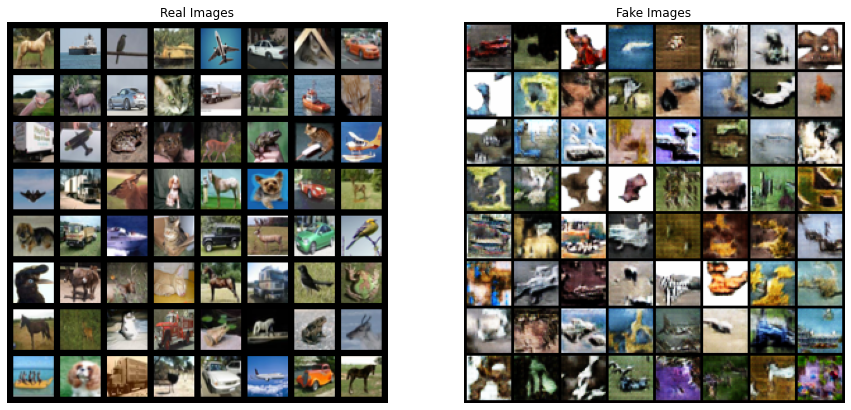

In [21]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [22]:
pic,a1,a2=netG(fixed_noise)
print(a1.shape)
print(a2.shape)

torch.Size([64, 64, 64])
torch.Size([64, 256, 256])


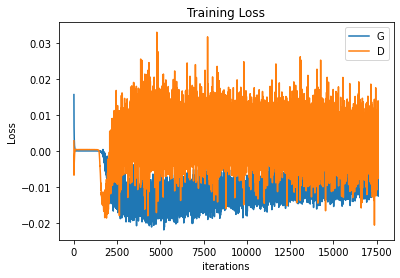

In [23]:
plt.title("Training Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
#plt.plot(fid_scores,label="fid_score")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./loss.jpg")
plt.show()

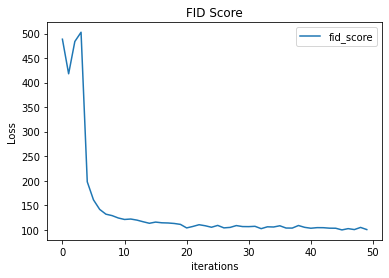

In [24]:
plt.title("FID Score")
#plt.plot(G_losses,label="G")
#plt.plot(D_losses,label="D")
plt.plot(fid_scores,label="fid_score")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./fid.jpg")
plt.show()

In [0]:
(data[3]/2+0.5).min()

tensor(0.0157)

i.shape

In [0]:
valloader.dataset.indices.shape


(5000,)

In [0]:
data1=iter(valloader).next()[0].numpy()

mu1,cov1=compute_mean_cov(data1)


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


2.4771561126206647


In [0]:
with torch.no_grad():
    data2,_=netG(fixed_noise)
data2=data2.numpy()
mu2,cov2=compute_mean_cov(data2)
print(calculate_frechet_distance(mu1,cov1,mu2,cov2))


100%|██████████| 2/2 [00:10<00:00,  5.35s/it]


1.6399166152736866


In [0]:
a.numpy()

array([[[[-1.70981288e-01, -1.54524250e-02, -4.99737859e-01, ...,
          -4.91245121e-01, -4.36812431e-01,  9.91213322e-02],
         [-5.59336007e-01,  2.31461674e-01, -3.23925018e-01, ...,
          -1.32002249e-01, -3.72526228e-01, -6.91320449e-02],
         [-5.88809699e-02,  7.52966940e-01, -5.03350079e-01, ...,
           7.80622125e-01, -6.07877016e-01,  8.45456868e-03],
         ...,
         [-3.65442902e-01, -7.85025775e-01, -6.87205017e-01, ...,
          -5.46298742e-01,  5.52418530e-02,  3.65202390e-02],
         [-1.02848455e-01, -3.76361549e-01, -6.66015267e-01, ...,
          -4.90951359e-01, -3.50697041e-01,  1.93917736e-01],
         [-1.50498807e-01, -2.85663754e-01, -3.14642280e-01, ...,
          -2.76441634e-01, -4.32219416e-01, -1.46380290e-01]],

        [[ 2.22333163e-01,  3.48274142e-01,  4.09538984e-01, ...,
          -2.25176930e-01,  9.73089710e-02, -2.18982678e-02],
         [-1.99313506e-01,  4.36243623e-01,  6.36626184e-01, ...,
          -2.48339206e